In [1]:
import os; 
import pandas as pd; pd.set_option('mode.chained_assignment',None)
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import re
import xlrd
import statistics as stat
from xlsxwriter.utility import xl_rowcol_to_cell
from random import sample
from src.data_models.SmartsCsvDataModel import SmartsCsvDataModel
from src.data_models.smartshelper import metrics, fixNum, unSMART, cparty
from src.data_models.SmartsDataModel import SmartsDataModel
from src.utility.DataModelUtility import execute_query_data_frame
from src.data_models.SmartsDataModel import SmartsDataModel
from src.data_models.UPMhelper import UPMalerts

/Users/sqian/.pyenv/versions/3.7.0/envs/env_370/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [20]:
lookback_1 = unSMART(pd.read_excel('~/Documents/vmfldr/alerts-LB1.xlsx'))
# lookback_1 = unSMART(pd.read_excel('~/Documents/vmfldr/smarts1JanApr.xlsx'))

# data = lookback_1[lookback_1['month'] == 12]
data0 = lookback_1.loc[lookback_1['Datetime'].dt.year == 2019]
data0b = data0.groupby(['month','AlertCode','ShortText']).count()

-> type fixed, kept 681 rows, 49 columns


In [21]:
pd.pivot_table(data0b,columns='month',index=['AlertCode','ShortText'],values='AlertID').fillna(0).astype(int)

month                                             1    2   3    4
AlertCode ShortText                                              
1001      (MC) UNUSUAL PRICE MOVEMENT INTRA-DAY   0    1   0    0
          UNUSUAL PRICE MOVEMENT INTRA-DAY       20   20   4    8
2011      UNUSUAL VOLUME INTRA-DAY                9   18  20   34
4009      PAINTING THE TAPE                       0    1   0    0
4012      PRICE DRIVER                            0    1   3    5
4022      BAIT AND SWITCH                        16  115  39  145
4023      LAYERING REPEAT                         0    0   2    1
4032      MULTI ORDER SPOOFING EOD               30   27  29   42
4042      WASH SALE A-B-A (MONEY PASS)           19   20  16   24
4045      COLLUSION(MONEY PASS)                   2    2   1    0

In [22]:
data0.groupby(['AlertCode']).count()['AlertID']

AlertCode
1001     53
2011     81
4009      1
4012      9
4022    315
4023      3
4032    128
4042     79
4045      5
Name: AlertID, dtype: int64

In [4]:
data0_1001 = data0[data0['AlertCode'] == 1001]
data0_1001['LT2'] = data0_1001['LongText'].str.extract(r'\D+:\s+(Price Change.+)\s+Bid.+')

for i in data0_1001['LT2'].head(): print(i,'\n')

Price Change in the last 5 minutes is +Ξ0.44940 (44.9%) from Ξ1.00010 to Ξ1.44950 and benchmark is Ξ0.31837 (25%)   Price Change in the last 10 minutes is +Ξ0.44940 (44.9%) from Ξ1.00010 to Ξ1.44950 and benchmark is Ξ0.31837 (25%) 

Price Change in the last 5 minutes is -Ξ0.49990 (50%) from Ξ1.00000 to Ξ0.50010 and benchmark is Ξ0.31837 (25%)   Price Change in the last 10 minutes is -Ξ0.49990 (50%) from Ξ1.00000 to Ξ0.50010 and benchmark is Ξ0.31837 (25%) 

Price Change in the last 5 minutes is +₿0.03868 (93%) from ₿0.04157 to ₿0.08025 and benchmark is ₿0.01045 (25%)   Price Change in the last 10 minutes is +₿0.03868 (93%) from ₿0.04157 to ₿0.08025 and benchmark is ₿0.01045 (25%)   Price Change in the last 1 hour is +₿0.03868 (93%) from ₿0.04157 to ₿0.08025 and benchmark is ₿0.02090 (50%) 

Price Change in the last 5 minutes is -0.76470 (76.5%) from 0.99990 to 0.23520 and benchmark is 0.05017 (25%)   Price Change in the last 10 minutes is -0.76470 (76.5%) from 0.99990 to 0.23520 and be

In [5]:
data1_1001 = data0_1001['LT2'].str.extractall(r'Price\D+(\d+\sminutes|hour)\D+([\d+.,]+)\D+([\d+.,]+)\D+([\d+.,]+)\D+([\d+.,]+)\D+([\d+.,]+)\D+([\d+.,]+)\D+').reset_index(drop=True)

In [6]:
data1_1001.columns = ['minutes','change_abs','change_pct','price0','price1','bm_abs','bm_pct']
data1_1001.head()

,minutes,change_abs,change_pct,price0,price1,bm_abs,bm_pct
0,5 minutes,0.44940,44.9,1.00010,1.44950,0.31837,25
1,5 minutes,0.49990,50,1.00000,0.50010,0.31837,25
2,5 minutes,0.03868,93,0.04157,0.08025,0.01045,25
3,5 minutes,0.76470,76.5,0.99990,0.23520,0.05017,25
4,5 minutes,0.55660,52.6,1.05740,0.50080,0.31837,25


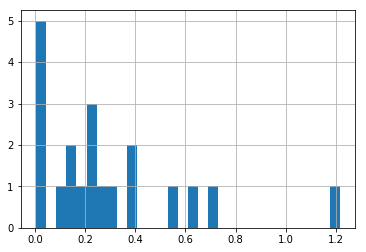

In [7]:
data1_1001['severity_abs'] = data1_1001['change_abs'].astype(float) - data1_1001['bm_abs'].astype(float)
data1_1001['severity_abs'].hist(bins=30)

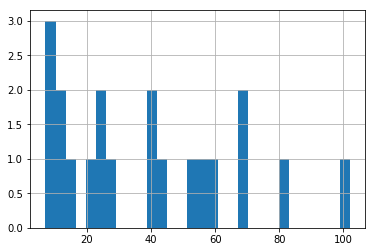

In [8]:
data1_1001['severity_bm'] = data1_1001['change_pct'].astype(float) - data1_1001['bm_pct'].astype(float)
data1_1001['severity_bm'].hist(bins=30)